# Notebook for training computer vision models for BugID

In [97]:
#Load libraries and constants
import timm
from fastai.vision.all import *
import pandas as pd
from torchvision import transforms
import torch
import cv2
import numpy as np

image_dir = Path("image_preproc")
model_dir = Path("models")
data_dir = Path("data")

img_size = 300

In [98]:
#Calculate weigths per class because of imbalanced data distribution
targets = [parent_label(i) for i in get_image_files(image_dir)]
count = Counter(targets)
wgts = [1/count[i] for i in targets]
n_classes = len(count)

In [99]:
#Define dataloaders
bs = 32

block = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(),
                  item_tfms=Resize(360, method=ResizeMethod.Crop), 
                  batch_tfms=aug_transforms(mult=1, size=img_size, min_scale=0.3, flip_vert=True),
                  get_y = parent_label)
    
loaders = block.weighted_dataloaders(image_dir, wgts=wgts, bs=bs)

In [5]:
#Write model vocabolary to file
vocab = loaders.vocab

with open(data_dir/"vocab.txt", 'w') as f:
    f.write('\n'.join(vocab))

In [6]:
#Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) # if p.requires_grad

In [7]:
#List learners to benchmark
learners = ["resnet18", "resnet34", "resnet50", 
            "mobilenetv2_050", "mobilenetv2_100", "mobilenetv2_140",
            "convnext_nano", "convnext_tiny"]

In [8]:
#Iterate over all learners and obtain validation statistics
results = []

for name in learners:
    
    #Define learner
    learn = vision_learner(loaders, 
                           name,
                           pretrained=True,
                           normalize=True,
                           loss_func=LabelSmoothingCrossEntropy(),
                           metrics=[accuracy, top_k_accuracy],
                           cbs=SaveModelCallback(fname=name)).to_fp16()

    #Fine-tune learner
    learn.fine_tune(epochs=15, freeze_epochs=3)

    #Count parameters
    n_params = count_parameters(learn)

    #Get validation set metrics
    preds, targets = learn.get_preds()

    val_acc = accuracy(preds, targets)
    val_top5 = top_k_accuracy(preds, targets)
    
    results.append({"model": name, "val_acc": val_acc.item(), "val_top5": val_top5.item(), "n_params": n_params})

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


KeyboardInterrupt: 

In [18]:
#Export benchmark results
results_df = pd.DataFrame(results)
results_df.to_csv(data_dir/"benchmark.csv", index=False)

In [63]:
#Load learner for inspection and export
model_name = "resnet18"

learn = vision_learner(loaders, 
                       model_name,
                       pretrained=True,
                       normalize=True).load(model_name)


/home/kenneth/anaconda3/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


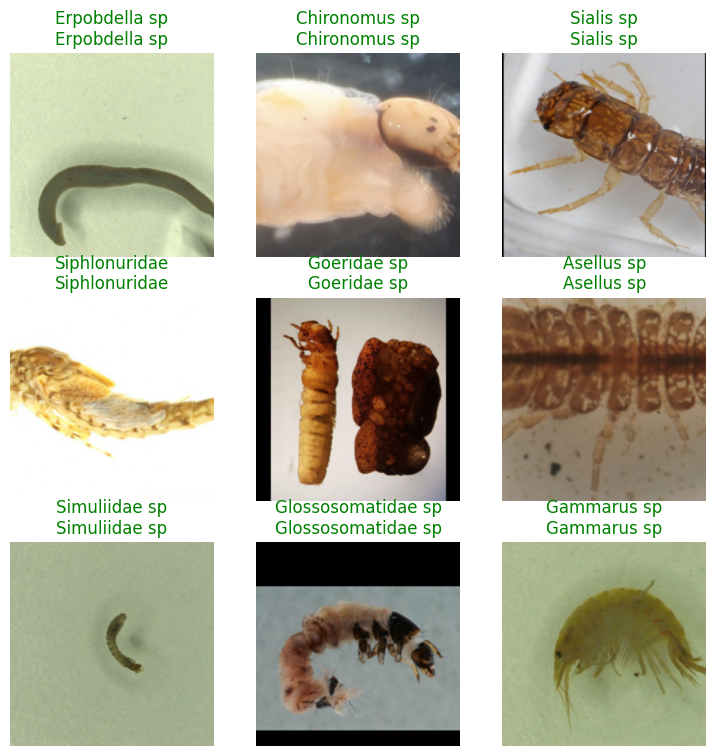

In [45]:
#Show example predictions
learn.show_results()

In [46]:
#Create confusion matrix
interpreter = ClassificationInterpretation.from_learner(learn)

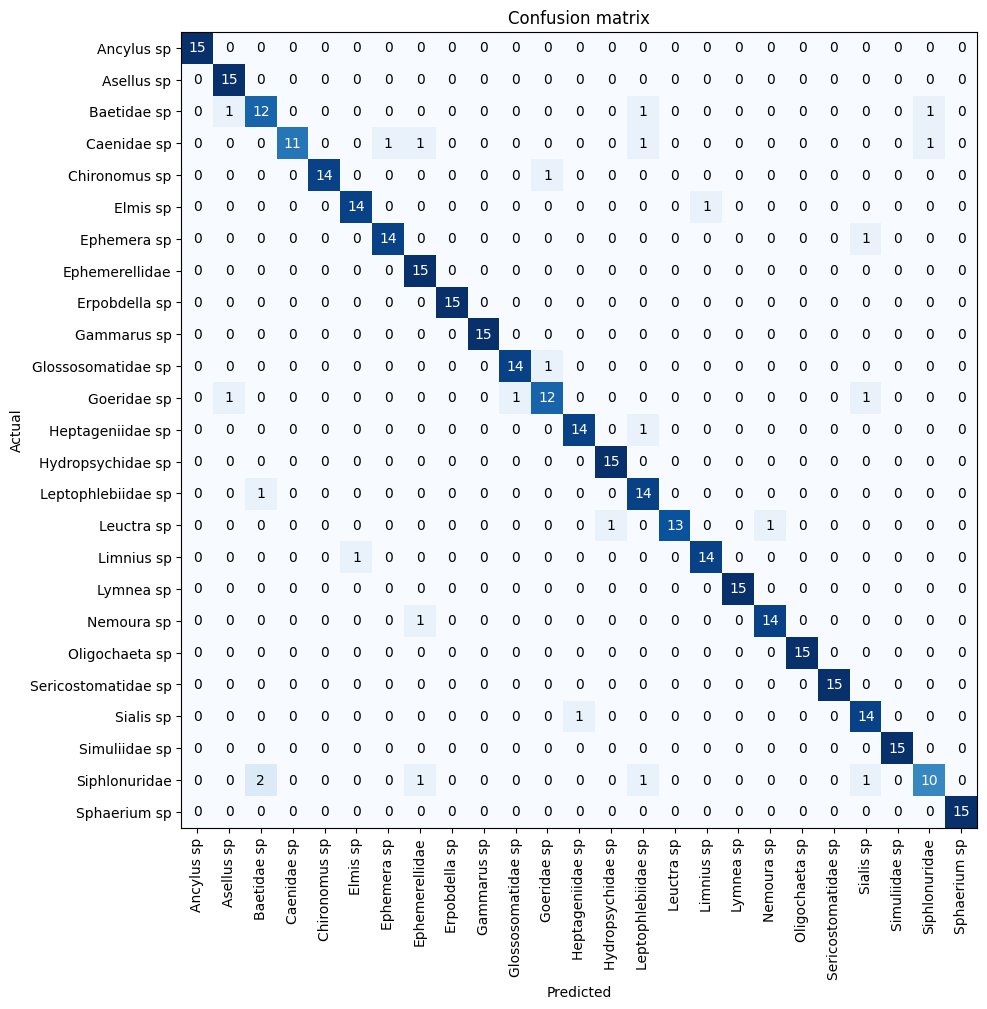

In [47]:
interpreter.plot_confusion_matrix(figsize=(10,10))

In [50]:
#Define normalization layer
normalization_layer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

torch_model = learn.model.cpu()

#Define softmax layer
softmax_layer = torch.nn.Softmax(dim=-1) 

#Assemble the final model
final_model = nn.Sequential(normalization_layer, torch_model, softmax_layer)
final_model.eval()

Sequential(
  (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  (1): Sequential(
    (0): TimmBody(
      (model): ConvNeXt(
        (stem): Sequential(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (stages): Sequential(
          (0): ConvNeXtStage(
            (downsample): Identity()
            (blocks): Sequential(
              (0): ConvNeXtBlock(
                (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
                (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
                (mlp): Mlp(
                  (fc1): Linear(in_features=96, out_features=384, bias=True)
                  (act): GELU(approximate='none')
                  (drop1): Dropout(p=0.0, inplace=False)
                  (fc2): Linear(in_features=384, out_features=96, bias=True)
                  (drop2): Dropout(p=0.0, inpl

In [51]:
#Generate model sample input
dummy_input = torch.randn(1, 3, img_size, img_size, requires_grad=True)

onnx_model_path = model_dir/f"{model_name}.onnx"

In [52]:
#https://docs.opencv.org/4.x/dc/d70/pytorch_cls_tutorial_dnn_conversion.html
#Model export into ONNX format
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_model_path,
    export_params=True,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output']
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [53]:
#Test fastai and ONNX model predictions
image_sample = "image_preproc/valid/Asellus sp/CPH-Asellus sp.-15.png"

In [54]:
#Get fastai predictions for sample image
spec, idx, probs = learn.predict(image_sample)

In [56]:
#Load ONNX model using opencv
model = cv2.dnn.readNetFromONNX(f"models/{model_name}.onnx")

In [57]:
#Preprocess sample image using opencv (similar to GUI)
model_input = cv2.dnn.blobFromImage(
                image = cv2.imread(image_sample),
                scalefactor = 1/255,
                size = (img_size, img_size),
                swapRB=True,
                crop=True)

In [58]:
#Get ONNX model predictions
model.setInput(model_input)
probs_onnx = model.forward().squeeze()

In [59]:
probs_onnx, probs.numpy()

(array([8.2853949e-04, 9.6375650e-01, 1.6533796e-03, 1.1963561e-03,
        1.2964871e-03, 1.4106217e-03, 4.9034850e-04, 3.2009569e-03,
        8.2076312e-04, 5.2053891e-03, 1.3194204e-03, 1.9815254e-03,
        1.3269279e-03, 2.0957631e-03, 9.2804723e-05, 1.5225316e-03,
        8.8084931e-04, 8.8289386e-04, 1.2455343e-03, 2.2344894e-03,
        1.1788394e-03, 2.2559348e-03, 5.5826904e-04, 3.6207677e-04,
        2.2027837e-03], dtype=float32),
 array([4.8243921e-04, 9.7709048e-01, 8.9755165e-04, 6.6905835e-04,
        7.8148709e-04, 1.0809393e-03, 2.7414050e-04, 2.7103636e-03,
        6.4904155e-04, 2.2524982e-03, 9.1297936e-04, 1.0719047e-03,
        9.2080975e-04, 1.0757814e-03, 6.1914259e-05, 1.0389142e-03,
        6.1400695e-04, 6.9514685e-04, 1.0027977e-03, 1.7104453e-03,
        5.7626568e-04, 1.3378040e-03, 2.9787171e-04, 2.6743326e-04,
        1.5279171e-03], dtype=float32))

In [78]:
#https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

#Shap image explanations

import shap
import torchvision

In [79]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
shap_model_name = "resnet34"
model = timm.create_model(shap_model_name, pretrained=False, num_classes = n_classes)
model.load_state_dict(torch.load(f"models/{shap_model_name}.pth"), strict=False)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [95]:
#sample1 = cv2.imread("image_preproc/valid/Asellus sp/CPH-Asellus sp.-15.png")
#sample1 = cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)
#sample2 = cv2.imread("image_preproc/valid/Elmis sp/CPH-Elmis sp.-667.png")
#sample2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)

ValueError: all input arrays must have the same shape

In [84]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x):
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x):
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x


transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Lambda(lambda x: x*(1/255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    torchvision.transforms.Lambda(nhwc_to_nchw),
    torchvision.transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    torchvision.transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img))
    img = img.to(device)
    output = model(img)
    return output

In [93]:
Xtr.shape

torch.Size([450, 600, 3])

In [89]:
Xtr = transform(torch.Tensor(sample1))
out = predict(Xtr[1:3])
#classes = torch.argmax(out, axis=1).cpu().numpy()
#print(f'Classes: {classes}: {np.array(class_names)[classes]}')

ValueError: expected 4D input (got 3D input)